## Natural Language Processing (NLP)

### Check for GPU

In [1]:
!nvidia-smi

Thu Dec 14 05:43:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Download the text dataset

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Get the train data
train_dataset, metadata_train = tfds.load(
    name = 'imdb_reviews',
    batch_size = 16,
    with_info = True,
    split = ['train'],
    as_supervised = True,
    shuffle_files = True
)

# Get the test data
test_dataset, metadata_test = tfds.load(
    name = 'imdb_reviews',
    batch_size = 16,
    with_info = True,
    split = ['test[:35%]'],
    as_supervised = True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteC230Z5/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteC230Z5/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteC230Z5/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
train_dataset[0]

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [4]:
test_dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>]

In [5]:
# Check count of train and test data
print("Number of samples in train data:", metadata_train.splits["train"].num_examples)
print("Number of samples in test data:", metadata_test.splits["test[:35%]"].num_examples)

Number of samples in train data: 25000
Number of samples in test data: 8750


In [6]:
train_dataset = train_dataset[0].shuffle(buffer_size = 1000).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [7]:
test_dataset = test_dataset[0].prefetch(tf.data.AUTOTUNE)
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [8]:
# Get one sample of the train data
it = iter(train_dataset)
text_data, labels = next(it)

In [9]:
for text, label in zip(text_data, labels):
  print(f'Given text: \n{text}\n')
  print(f"Given label: {'Negative' if label==0 else 'Positive'}")
  print()

Given text: 
b"This is one of the funniest movies I have seen. I watched it on DVD, and the disc does not have any special features, or even a menu, but that is not necessarily what I care about. <br /><br />I tend to judge movies on a case by case basis, depending on, among other things, if it is a big studio production or a smaller film. This is a smaller film and I am willing to forgive minor things. That said, I believe it has one of the most imaginative and original title sequences that I have seen.<br /><br />I enjoyed the acting of all of the major players. I especially enjoyed Til Schweiger and Alan Arkin. Alan Arkin has most of the funniest lines. The character portrayed by Claire Forlani might come across as unrealistic to some people, but I have personally known real people with emotional problems that very readily look at life's decisions as her character does. That helped me pick up the nuances where her hurts could come out through the veneer of her humor.<br /><br />This

In [10]:
text_data.numpy()[3]

b"OK maybe a 13 year old like me was a little to old for this movie. Its about this pampered rat, who lives in a palace. Then a sewer rat flushes him down a toilet! He ends up in this rat city and meets this girl rat who has a gem a greedy frog wants. He will do anything for this gem he sends a whole army after these two rats.He plans to take the gem and to flood rat city! THe cool part about this movie is the slugs. They do all the sound effects. They sing, make noises, its awesome, its also pretty funny. OK bottom line, it is aimed at 7 year olds. Other wise, a great movie to take a younger family member to see. I didn't think the animation was real dreamworks art though, more like WAllace and Gromit. i thinkthey slacked a little on that. The movie was just decent, not worth spending $9.50 for though, sorry."

### Preprocessing the text data

#### Tokenization

In [40]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = None,
                                    standardize = 'lower_and_strip_punctuation',
                                    output_mode = 'int',
                                    split="whitespace",
                                    output_sequence_length=None)

In [12]:
# Get average number of tokens in the one training batch
round(sum([len(i.split()) for i in text_data.numpy()])/len(text_data))

154

In [44]:
max_length = 211
max_vocab_length = 15000

# text vectorizer with custom variables
text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    standardize = 'lower_and_strip_punctuation',
                                    output_mode = 'int',
                                    split="whitespace",
                                    output_sequence_length=max_length,
                                    pad_to_max_tokens=True)

In [14]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [45]:
# Adapt the text_vectorizer to the train dataset
text_vectorizer.adapt(train_dataset.unbatch().map(lambda x, y: x).batch(16))

In [16]:
### Get training text data and labels
df = train_dataset.unbatch()
df.as_numpy_iterator()

In [38]:
# Check value counts in the train dataset
train_label_lst = [label for _, label in df.as_numpy_iterator()]
train_label_lst[:10]

[1, 0, 1, 1, 1, 1, 0, 1, 0, 0]

In [39]:
from collections import Counter
Counter(train_label_lst)

Counter({1: 12500, 0: 12500})

In [17]:
# Create sample sentence and tokenize it
sample_sentence = 'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.'
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 211), dtype=int64, numpy=
array([[   11,     7,     2,   319,     5,    21,    16,     4,     1,
         6209,  6241,    54,     2,   492,     5,     2,   244,    78,
          172,  2842,    17,    32,   258,  1729,    15,    24,     1,
           90,     4,   254,     1,     3,     1,    16,     4,   532,
            5,  1004,   544,   498,    38,     1,     3,     1,  4078,
           15,   266,     1,  8842,     2,   137,   514,    50,    25,
           62,     1,     6,  4442,    62,  3745,  9915,    43,     4,
         5499,     3,  4039,     1,   176,   200,  1295,   146,    33,
           32,   138,     4,   293,    21,     8,   217,   392,     3,
           30,    12,  1744,     2,  6835,     9,  4210,    86,   124,
         2182,   377,  2103,  2077,   185,     1,     1,     1,     1,
          506,   546,   671,    20,   569,     1, 11239, 13697,     1,
         2403,  2184,     1,     1,  2558,     1,     1,   505,   899,
            1,     1,     1, 

In [18]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 15000
Top 5 most common words: ['', '[UNK]', 'the', 'and', 'a']
Bottom 5 least common words: ['learn to', 'knows what', 'kissing', 'justice to', 'just have to']


#### Embedding layer

In [19]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length,
                             output_dim = 128,
                             embeddings_initializer = 'uniform',
                             input_length = max_length,
                             name= 'embedding_1')

In [20]:
# Create sample sentence and tokenize it, then ambed it
sample_sentence = 'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.'
embedding(text_vectorizer([sample_sentence]))

<tf.Tensor: shape=(1, 211, 128), dtype=float32, numpy=
array([[[-0.00090529, -0.01822349, -0.03992208, ..., -0.01944376,
          0.01288996,  0.00746803],
        [ 0.04281517, -0.00682018, -0.02213605, ..., -0.00847484,
          0.04984871, -0.0022126 ],
        [ 0.01466331,  0.01856694, -0.02121229, ..., -0.01077056,
         -0.02306392, -0.00571278],
        ...,
        [ 0.00812279,  0.02246965,  0.03829056, ...,  0.00981563,
         -0.02933923, -0.04062592],
        [ 0.00546124, -0.00470512, -0.03733848, ...,  0.0346949 ,
         -0.03155955, -0.0075594 ],
        [ 0.00812279,  0.02246965,  0.03829056, ...,  0.00981563,
         -0.02933923, -0.04062592]]], dtype=float32)>

## Modelling on the text data

In [46]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_metrics(y_true, y_pred):
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)

  # Calculate model precision, recall and f1-score usign 'weighted' average
  model_precision, model_recall, model_f1,_ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

  model_results = {
      "accuracy": model_accuracy,
      "precision": model_precision,
      "recall": model_recall,
      "f1": model_f1
  }

  return model_results

In [47]:
# Create the model checkpoint callback
def create_model_checkpoint(save_dir):
  return tf.keras.callbacks.ModelCheckpoint(filepath = save_dir,
                                            monitor = 'val_accuracy',
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            verbose = 0)

In [48]:
# Plot loss curves of the model
import matplotlib.pyplot as plt
def plot_loss_curves(history, metrics_to_plot=["loss", "accuracy"]):
    plt.figure(figsize=(10, 10))
    for index, metric in enumerate(metrics_to_plot):
        ax = plt.subplot(len(metrics_to_plot), 1, index + 1)
        plt.plot(history.history[metric], label=f"training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"val {metric}")
        plt.title(f"{metric} vs Epochs curve")
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.tight_layout()
        plt.legend()

In [49]:
# Making a function to compare histories at any time
def compare_history_overall(
    history_lst=[], initial_epoch_lst=[5], metrics_to_plot=["loss", "accuracy"]
):
    plt.figure(figsize=(12, 12))
    for index, metric in enumerate(metrics_to_plot):
        total_mtr = history_lst[0].history[metric]
        total_val_mtr = history_lst[0].history[f"val_{metric}"]

        for history in history_lst[1:]:
            total_mtr = total_mtr + history.history[metric]
            total_val_mtr = total_val_mtr + history.history[f"val_{metric}"]

        plt.subplot(2, 1, index + 1)
        plt.plot(total_mtr, label=f"Training {metric}")
        plt.plot(total_val_mtr, label=f"Validation {metric}")

        for epoch in initial_epoch_lst:
            plt.plot([epoch - 1, epoch - 1], plt.ylim())

        plt.title(f"Training and validation {metric}")
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.tight_layout()
        plt.legend()

In [50]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def get_range_epoch_results(
    model,
    epoch_lst=[5, 20],
    callbacks=None,
    loss_fn="binary_crossentropy",
    train_data=train_dataset,
    test_data=test_dataset,
    learning_rate=0.001,
    use_best_only = False,
    optimizer = 'adam'
):
    history_lst = []
    eval_res = []

    epoch_lst = [0] + epoch_lst
    for index, epoch in enumerate(epoch_lst[1:]):
        checkpoint_path = f"model_exp/{model.name}_{index}.ckpt"
        if index == 0:
            model.compile(loss=loss_fn,
                          optimizer=Adam() if optimizer=='adam' else optimizer,
                          metrics=["accuracy"])

        # Make the callback list
        if use_best_only and callbacks != None:
            callbacks += [
                create_model_checkpoint(save_dir=checkpoint_path)
            ]
        elif use_best_only and callbacks == None:
            callbacks = [
                create_model_checkpoint(save_dir=checkpoint_path)
            ]
        else: callbacks = callbacks

        # Set the initial_epoch and train the data from it
        initial_epoch = epoch_lst[index]
        print(
            f"Fitting and training the model: \n  Initial epochs: {initial_epoch}\n  Total epochs: {epoch}\n"
        )
        model_history = model.fit(
            train_data,
            steps_per_epoch=len(train_data),
            epochs=epoch,
            initial_epoch=initial_epoch,
            validation_data=test_data,
            validation_steps=len(test_data),
            verbose=0,
            callbacks=callbacks,
        )

        print(f"Trained the model till {epoch} epochs!!!\n")

        # Load in the best model
        if use_best_only:
          print(f"Model saved at checkpoint path: `{checkpoint_path}`")
          print(f"Loading the best weights model {index + 1}")
          model.load_weights(checkpoint_path)

        # Evaluating the model
        print("Getting the evaluation results")
        eval_res.append(model.evaluate(test_data))

        history_lst.append(model_history)

        print()
        print("-" * 50)
        print()

    return history_lst, eval_res

### Model 1: Simple dense model

In [51]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string, name = 'input_layer')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid', name = 'output_layer')(x)
model_1 = tf.keras.Model(inputs, outputs, name = 'model_1_dense')

In [ ]:
# Compile the model
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

# Fit the model
model_1_history = model_1.fit(train_dataset,
                              epochs = 15,
                              steps_per_epoch = len(train_dataset),
                              validation_data = test_dataset,
                              validation_steps = len(test_dataset),
                              callbacks = [create_model_checkpoint(
                                  save_dir = 'model_exp/model_1_dense'
                              )])

Epoch 1/15
1563/1563 [==============================] - 40s 22ms/step - loss: 0.4569 - accuracy: 0.8047 - val_loss: 0.3372 - val_accuracy: 0.8608
Epoch 2/15
1563/1563 [==============================] - 16s 10ms/step - loss: 0.2720 - accuracy: 0.8911 - val_loss: 0.3102 - val_accuracy: 0.8717
Epoch 3/15
1563/1563 [==============================] - 17s 11ms/step - loss: 0.2176 - accuracy: 0.9171 - val_loss: 0.3190 - val_accuracy: 0.8681
Epoch 4/15
1563/1563 [==============================] - 15s 9ms/step - loss: 0.1836 - accuracy: 0.9323 - val_loss: 0.3393 - val_accuracy: 0.8615
Epoch 5/15
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1578 - accuracy: 0.9423 - val_loss: 0.3691 - val_accuracy: 0.8550
Epoch 6/15
1563/1563 [==============================] - 15s 9ms/step - loss: 0.1377 - accuracy: 0.9512 - val_loss: 0.4036 - val_accuracy: 0.8507
Epoch 7/15
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1206 - accuracy: 0.9590 - val_loss: 0.4439 - v

In [ ]:
# Evaluate on the test data
model_1.evaluate(test_dataset)

547/547 [==============================] - 6s 10ms/step - loss: 0.8919 - accuracy: 0.8211


[0.8919285535812378, 0.821142852306366]

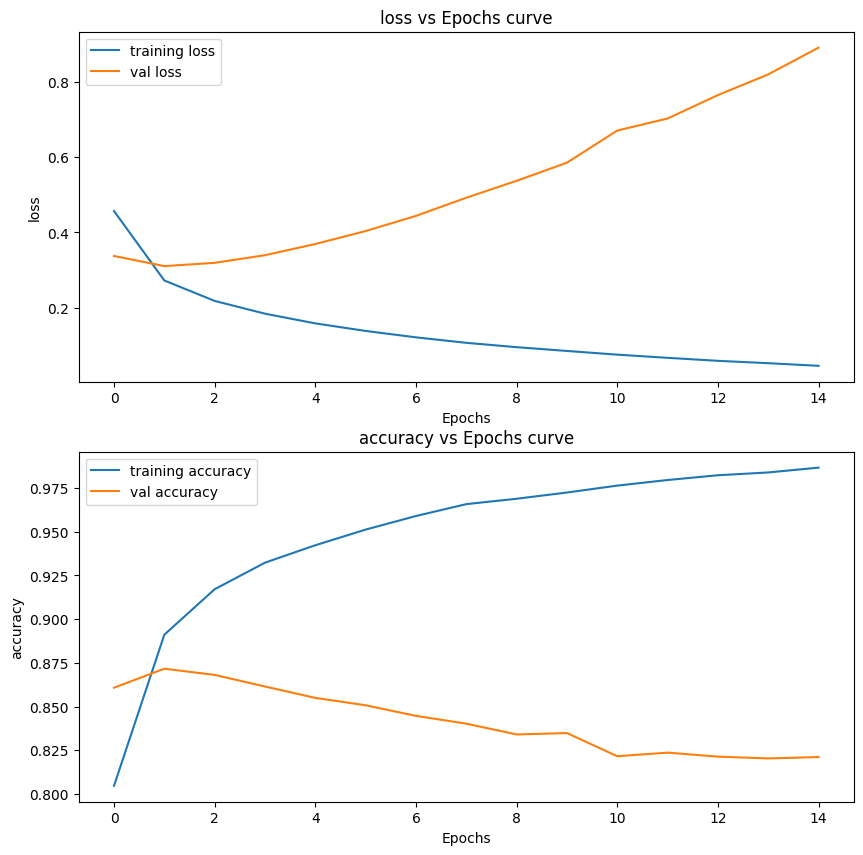

In [ ]:
# Plot the loss curves
plot_loss_curves(model_1_history)

In [ ]:
# Load the model with best weights
model_1.load_weights('model_exp/model_1_dense')

In [ ]:
model_1.evaluate(test_dataset)

547/547 [==============================] - 7s 12ms/step - loss: 0.3102 - accuracy: 0.8717


[0.3102083206176758, 0.871657133102417]

In [ ]:
# Make predictions using the model
model_1_pred_probs = model_1.predict(test_dataset)
model_1_pred_probs

547/547 [==============================] - 6s 10ms/step


array([[0.72786707],
       [0.62529093],
       [0.00643946],
       ...,
       [0.06051769],
       [0.16403061],
       [0.6419859 ]], dtype=float32)

In [ ]:
# Convert the pred probs to labels
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds

<tf.Tensor: shape=(8750,), dtype=float32, numpy=array([1., 1., 0., ..., 0., 0., 1.], dtype=float32)>

In [ ]:
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 0., 0., 1., 1., 1., 1., 0., 0.], dtype=float32)>

In [ ]:
model_1_preds.shape

TensorShape([8750])

In [26]:
# Get all labels of the test dataset
t_ds = test_dataset.unbatch()
test_label_lst = [label for _, label in t_ds.as_numpy_iterator()]
test_label_lst[:10]

[1, 1, 0, 0, 1, 1, 1, 1, 0, 1]

In [ ]:
len(test_label_lst), len(model_1_preds)

In [ ]:
model_1_results = calculate_metrics(y_true = test_label_lst,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 0.8716571428571429,
 'precision': 0.8719366208139356,
 'recall': 0.8716571428571429,
 'f1': 0.8716565846442259}

In [ ]:
print(classification_report(y_true = test_label_lst,
                      y_pred = model_1_preds,
                      target_names = ['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.88      0.86      0.87      4429
    positive       0.86      0.88      0.87      4321

    accuracy                           0.87      8750
   macro avg       0.87      0.87      0.87      8750
weighted avg       0.87      0.87      0.87      8750



In [52]:
# Train the model on range of epochs
history_model_1_lst, model_1_eval_lst = get_range_epoch_results(
    model_1,
    epoch_lst=[5, 10, 15, 20, 25, 30, 35],
    callbacks=None,
    loss_fn="binary_crossentropy",
    train_data=train_dataset,
    test_data=test_dataset,
    learning_rate=0.001,
    use_best_only = True,
    optimizer = 'adam'
)

Fitting and training the model: 
  Initial epochs: 0
  Total epochs: 5

Trained the model till 5 epochs!!!

Model saved at checkpoint path: `model_exp/model_1_dense_0.ckpt`
Loading the best weights model 1
Getting the evaluation results
547/547 [==============================] - 2s 4ms/step - loss: 0.3184 - accuracy: 0.8712

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 5
  Total epochs: 10

Trained the model till 10 epochs!!!

Model saved at checkpoint path: `model_exp/model_1_dense_1.ckpt`
Loading the best weights model 2
Getting the evaluation results
547/547 [==============================] - 2s 4ms/step - loss: 0.3240 - accuracy: 0.8685

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 10
  Total epochs: 15

Trained the model till 15 epochs!!!

Model saved at checkpoint path: `model_exp/model_1_dense_2.ckpt`
Loading the best weights model 3
Getting the evaluation results


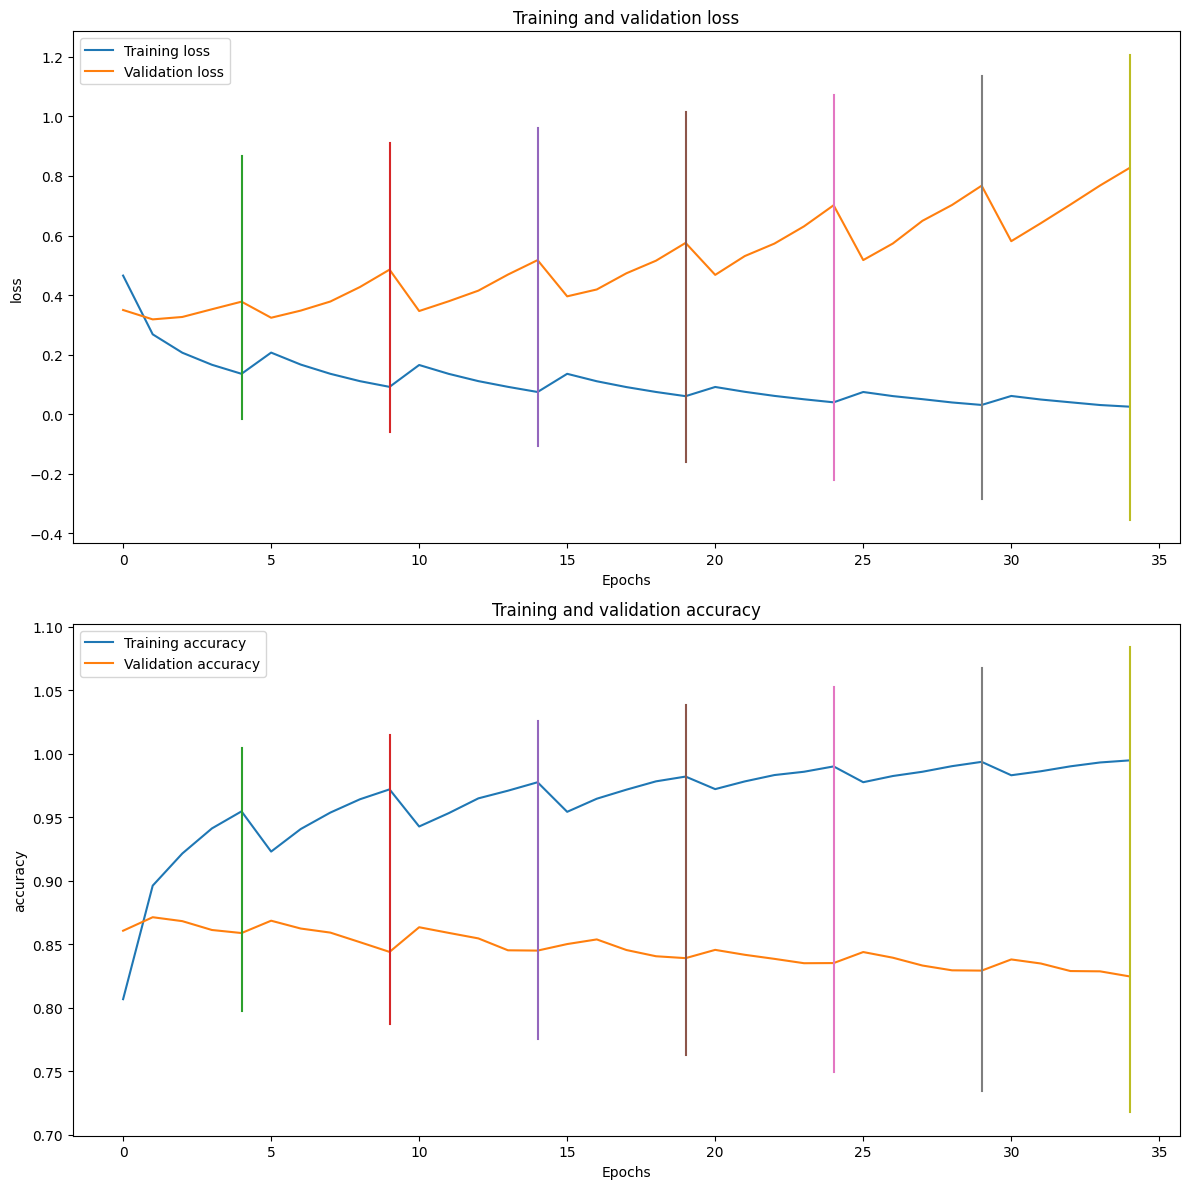

In [53]:
compare_history_overall(history_lst=history_model_1_lst,
                        initial_epoch_lst=[5, 10, 15, 20, 25, 30, 35])

### Model 2: A little bigger model

In [ ]:
# set the random seed
inputs = layers.Input(shape=(1,), dtype=tf.string, name='input_layer')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(24, 3, activation='elu')(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation='elu')(x)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs, name = 'model_2')

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 211)               0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 211, 128)          1920000   
                                                                 
 conv1d (Conv1D)             (None, 209, 24)           9240      
                                                                 
 global_average_pooling1d_1  (None, 24)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense (Dense)               (None, 32)                800 

In [ ]:
# Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

# Fit the model
model_2_history = model_2.fit(train_dataset,
                              epochs = 15,
                              steps_per_epoch = len(train_dataset),
                              validation_data = test_dataset,
                              validation_steps = int(0.5 * len(test_dataset)),
                              callbacks = [create_model_checkpoint(
                                  save_dir = 'model_exp/model_2'
                              )])

Epoch 1/15
1563/1563 [==============================] - 60s 32ms/step - loss: 0.2200 - accuracy: 0.9160 - val_loss: 0.3385 - val_accuracy: 0.8615
Epoch 2/15
1563/1563 [==============================] - 28s 18ms/step - loss: 0.1762 - accuracy: 0.9342 - val_loss: 0.3722 - val_accuracy: 0.8533
Epoch 3/15
1563/1563 [==============================] - 27s 17ms/step - loss: 0.1428 - accuracy: 0.9480 - val_loss: 0.3971 - val_accuracy: 0.8459
Epoch 4/15
1563/1563 [==============================] - 17s 11ms/step - loss: 0.1049 - accuracy: 0.9601 - val_loss: 0.4711 - val_accuracy: 0.8294
Epoch 5/15
1563/1563 [==============================] - 15s 10ms/step - loss: 0.0683 - accuracy: 0.9699 - val_loss: 0.7402 - val_accuracy: 0.8413
Epoch 6/15
1563/1563 [==============================] - 17s 11ms/step - loss: 0.0439 - accuracy: 0.9813 - val_loss: 0.9209 - val_accuracy: 0.8352
Epoch 7/15
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0305 - accuracy: 0.9879 - val_loss: 1.2839 -

In [ ]:
# Evaluate the model
model_2.evaluate(test_dataset)

547/547 [==============================] - 6s 11ms/step - loss: 1.6192 - accuracy: 0.8306


[1.619224190711975, 0.8306285738945007]

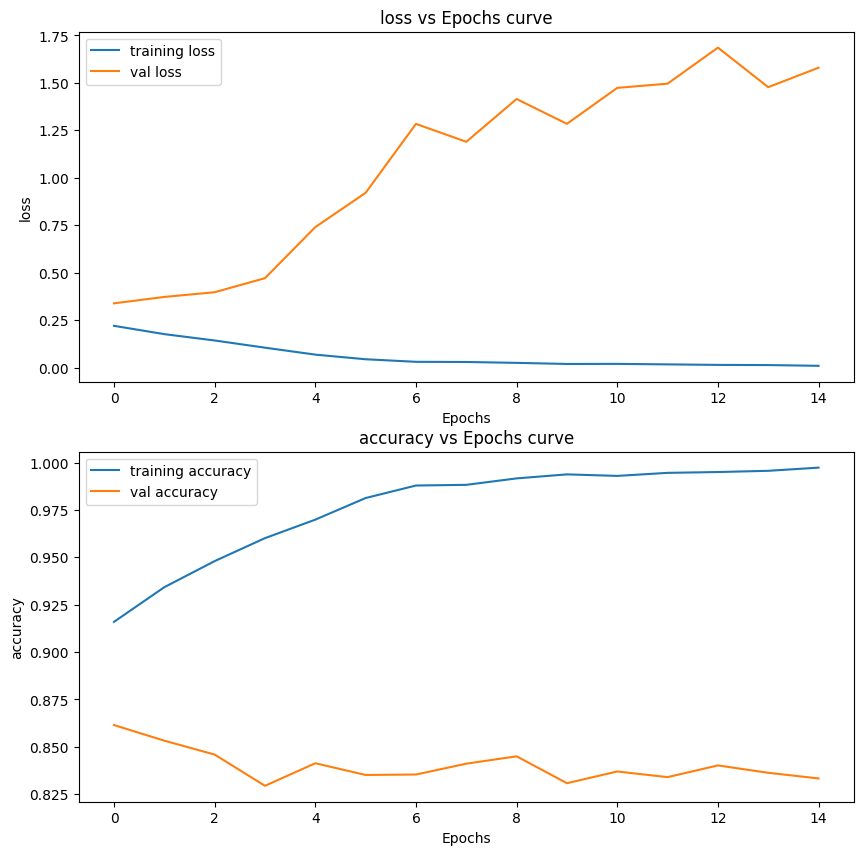

In [ ]:
# Plot the loss curves
plot_loss_curves(model_2_history)

In [ ]:
# Load the model with best weights
model_2.load_weights('model_exp/model_2')
model_2.evaluate(test_dataset)

547/547 [==============================] - 4s 7ms/step - loss: 0.3385 - accuracy: 0.8608


[0.338522344827652, 0.86080002784729]

In [ ]:
# Making predictions using the model
model_2_pred_probs = model_2.predict(test_dataset)
model_2_pred_probs[:10]

547/547 [==============================] - 3s 5ms/step


array([[0.9060089 ],
       [0.39756712],
       [0.00820166],
       [0.0949864 ],
       [0.99122965],
       [0.97973895],
       [0.99801576],
       [0.99671376],
       [0.62841934],
       [0.126155  ]], dtype=float32)

In [ ]:
# Converting the prediction probabilities into labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculating the results
model_2_results = calculate_metrics(y_true = test_label_lst,
                                    y_pred = model_2_preds)

In [ ]:
model_2_results

{'accuracy': 0.8608,
 'precision': 0.8628887310534102,
 'recall': 0.8608,
 'f1': 0.860674641835069}

In [ ]:
print(classification_report(y_true = test_label_lst,
                      y_pred = model_2_preds,
                      target_names = ['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.89      0.83      0.86      4429
    positive       0.83      0.90      0.86      4321

    accuracy                           0.86      8750
   macro avg       0.86      0.86      0.86      8750
weighted avg       0.86      0.86      0.86      8750



In [ ]:
model_1_results

{'accuracy': 0.8716571428571429,
 'precision': 0.8719366208139356,
 'recall': 0.8716571428571429,
 'f1': 0.8716565846442259}

### Model 3: Same as model_2, but with ReduceLRonplateau and earlystopping callback

In [ ]:
# set the random seed
inputs = layers.Input(shape=(1,), dtype=tf.string, name='input_layer')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(24, 3, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)
model_3 = tf.keras.Model(inputs, outputs, name = 'model_3')

In [ ]:
# Create ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 mode = 'max',
                                                 factor=0.2,
                                                 patience=3,
                                                 min_lr=1e-5,
                                                 verbose = 0)

# Create Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              mode = 'max',
                                              patience = 10,
                                              verbose = 0,
                                              restore_best_weights = True)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model_3.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

# Fit the model
model_3_history = model_3.fit(train_dataset,
                              epochs = 25,
                              steps_per_epoch = len(train_dataset),
                              validation_data = test_dataset,
                              validation_steps = len(test_dataset),
                              callbacks = [reduce_lr, early_stop])

Epoch 1/25
1563/1563 [==============================] - 40s 24ms/step - loss: 0.1869 - accuracy: 0.9304 - val_loss: 0.3806 - val_accuracy: 0.8520 - lr: 0.0010
Epoch 2/25
1563/1563 [==============================] - 21s 13ms/step - loss: 0.1378 - accuracy: 0.9531 - val_loss: 0.4217 - val_accuracy: 0.8473 - lr: 0.0010
Epoch 3/25
1563/1563 [==============================] - 28s 18ms/step - loss: 0.1139 - accuracy: 0.9610 - val_loss: 0.4296 - val_accuracy: 0.8414 - lr: 0.0010
Epoch 4/25
1563/1563 [==============================] - 17s 11ms/step - loss: 0.0914 - accuracy: 0.9714 - val_loss: 0.5683 - val_accuracy: 0.8385 - lr: 0.0010
Epoch 5/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0585 - accuracy: 0.9863 - val_loss: 0.5768 - val_accuracy: 0.8374 - lr: 2.0000e-04
Epoch 6/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0522 - accuracy: 0.9886 - val_loss: 0.6236 - val_accuracy: 0.8358 - lr: 2.0000e-04
Epoch 7/25
1563/1563 [================

In [ ]:
# Evaluating the model on test data
model_3.evaluate(test_dataset)

547/547 [==============================] - 3s 6ms/step - loss: 0.3806 - accuracy: 0.8520


[0.38056680560112, 0.8519999980926514]

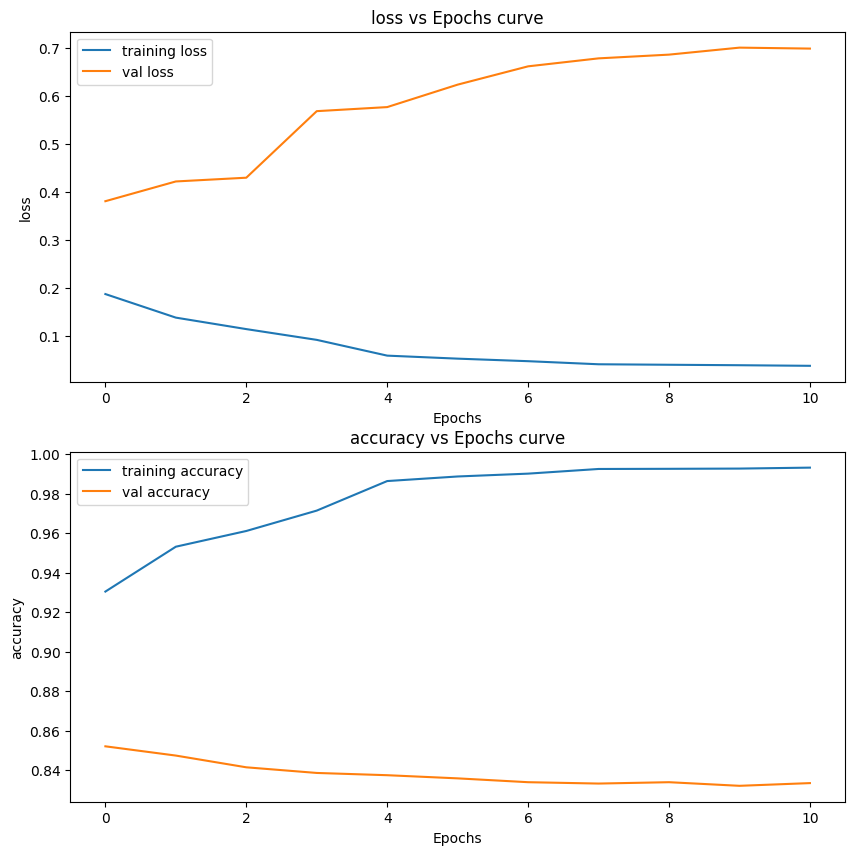

In [ ]:
# Plot the loss curves
plot_loss_curves(model_3_history)

In [ ]:
# Get model predictions
model_3_preds = tf.squeeze(tf.round(model_3.predict(test_dataset)))
model_3_preds

547/547 [==============================] - 3s 5ms/step


<tf.Tensor: shape=(8750,), dtype=float32, numpy=array([1., 0., 0., ..., 0., 0., 1.], dtype=float32)>

In [ ]:
# Get evaluation metrics
model_3_results = calculate_metrics(y_true=test_label_lst,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 0.852,
 'precision': 0.8521029763276994,
 'recall': 0.852,
 'f1': 0.8519671893208023}

In [ ]:
# Get classification report
from sklearn.metrics import classification_report
print(classification_report(y_true = test_label_lst,
                      y_pred = model_3_preds,
                      target_names = ['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.85      0.86      0.86      4429
    positive       0.86      0.84      0.85      4321

    accuracy                           0.85      8750
   macro avg       0.85      0.85      0.85      8750
weighted avg       0.85      0.85      0.85      8750



### Model 4: LSTM model

In [ ]:
# set the random seed
tf.random.set_seed(42)

# Create the model
inputs = layers.Input(shape=(1,), dtype=tf.string, name='input_layer')
x = text_vectorizer(inputs)
x = embedding(x)  #  shape -> (None, 211, 128)
x = layers.LSTM(64, return_sequences=True)(x)  # shape -> (None, 211, 64)
x = layers.LSTM(32, return_sequences=True)(x)  # shape -> (None, 211, 32)
x = layers.GlobalMaxPooling1D()(x)    # shape -> (None, 32)
x = layers.Dense(32, activation='relu')(x)    # shape -> (None, 32)
x = layers.Dense(16, activation='relu')(x)  # shape -> (None, 16)
outputs = layers.Dense(1, activation='sigmoid', name = 'output_layer')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4')

In [ ]:
# Compile the model
model_4.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy', 'Precision', 'AUC'])

# Create ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 mode = 'max',
                                                 factor=0.2,
                                                 patience=5,
                                                 min_lr=1e-5,
                                                 verbose = 0)

# Fit the model
model_4_history = model_4.fit(train_dataset,
                              epochs = 15,
                              steps_per_epoch = len(train_dataset),
                              validation_data = test_dataset,
                              validation_steps = int(0.75*len(test_dataset)),
                              callbacks = [reduce_lr, early_stop])

Epoch 1/15
1563/1563 [==============================] - 65s 39ms/step - loss: 0.1969 - accuracy: 0.9230 - precision: 0.9279 - auc: 0.9758 - val_loss: 0.4347 - val_accuracy: 0.8465 - val_precision: 0.8543 - val_auc: 0.9239 - lr: 0.0010
Epoch 2/15
1563/1563 [==============================] - 57s 36ms/step - loss: 0.1404 - accuracy: 0.9484 - precision: 0.9476 - auc: 0.9868 - val_loss: 0.5029 - val_accuracy: 0.8348 - val_precision: 0.8831 - val_auc: 0.9168 - lr: 0.0010
Epoch 3/15
1563/1563 [==============================] - 49s 31ms/step - loss: 0.1015 - accuracy: 0.9649 - precision: 0.9646 - auc: 0.9924 - val_loss: 0.4292 - val_accuracy: 0.8375 - val_precision: 0.8295 - val_auc: 0.9168 - lr: 0.0010
Epoch 4/15
1563/1563 [==============================] - 39s 25ms/step - loss: 0.0679 - accuracy: 0.9776 - precision: 0.9774 - auc: 0.9959 - val_loss: 0.6484 - val_accuracy: 0.8334 - val_precision: 0.7972 - val_auc: 0.9031 - lr: 0.0010
Epoch 5/15
1563/1563 [==============================] - 39s 

In [ ]:
# Evaluate the model
model_4.evaluate(test_dataset)

547/547 [==============================] - 8s 14ms/step - loss: 0.4357 - accuracy: 0.8467 - precision: 0.8524 - auc: 0.9238


[0.4356924593448639,
 0.8467428684234619,
 0.8524124622344971,
 0.9238157868385315]

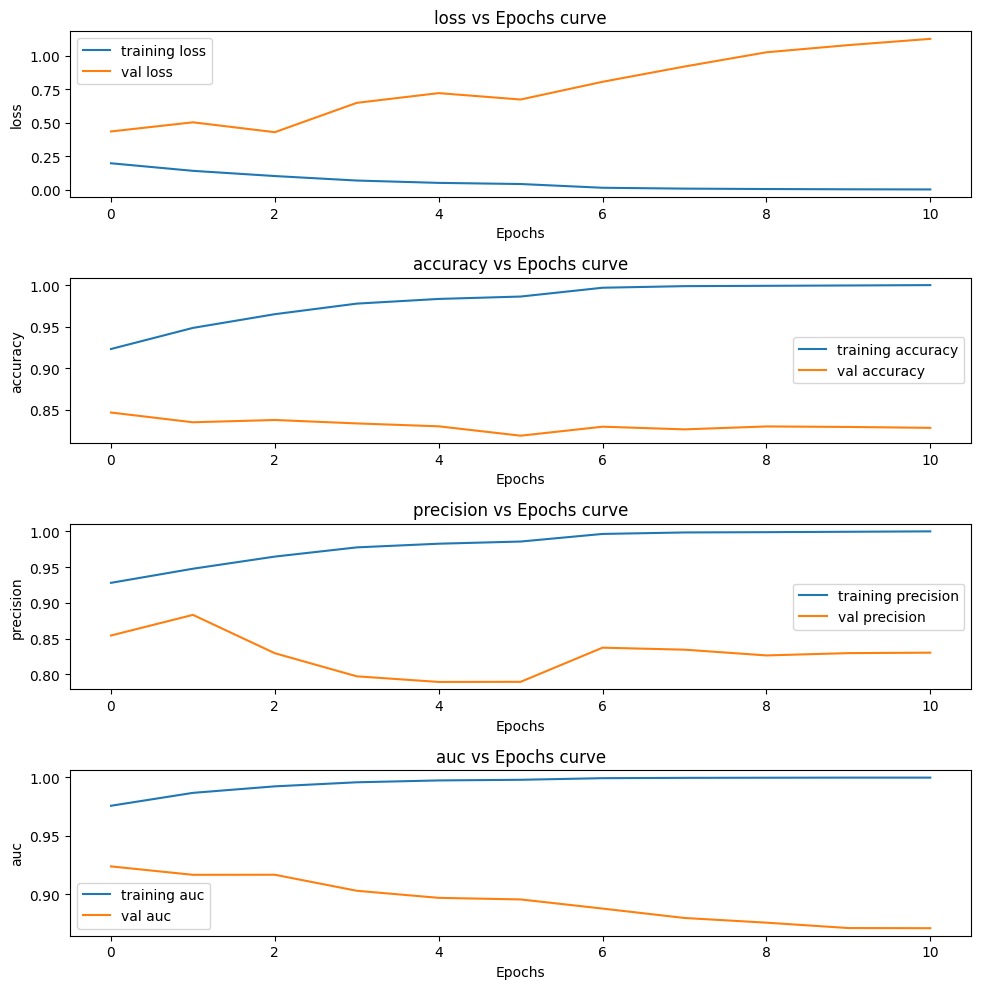

In [ ]:
# Plot the loss curves
plot_loss_curves(model_4_history, metrics_to_plot=['loss',
                                                   'accuracy',
                                                   'precision',
                                                   'auc'])

In [ ]:
# Making a predictions on test and train data
model_4_train_preds = tf.squeeze(tf.round(model_4.predict(train_dataset)))
model_4_preds = tf.squeeze(tf.round(model_4.predict(test_dataset)))
model_4_preds

547/547 [==============================] - 9s 16ms/step


<tf.Tensor: shape=(8750,), dtype=float32, numpy=array([1., 0., 0., ..., 0., 0., 1.], dtype=float32)>

In [ ]:
# Get all train label
t_ds = train_dataset.unbatch()
train_label_lst = [label for _, label in t_ds.as_numpy_iterator()]

In [ ]:
# Checking the model results
model_4_results=  calculate_metrics(y_true = test_label_lst, y_pred = model_4_preds)
model_4_train_results=  calculate_metrics(y_true = train_label_lst, y_pred = model_4_train_preds)

model_4_results, model_4_train_results

({'accuracy': 0.8467428571428571,
  'precision': 0.8468594594617213,
  'recall': 0.8467428571428571,
  'f1': 0.8467054191241818},
 {'accuracy': 0.50048,
  'precision': 0.5004800196616054,
  'recall': 0.50048,
  'f1': 0.500474884862821})

In [ ]:
model_1_results

{'accuracy': 0.8716571428571429,
 'precision': 0.8719366208139356,
 'recall': 0.8716571428571429,
 'f1': 0.8716565846442259}

In [ ]:
model_2_results

{'accuracy': 0.8608,
 'precision': 0.8628887310534102,
 'recall': 0.8608,
 'f1': 0.860674641835069}

In [ ]:
model_3_results

{'accuracy': 0.852,
 'precision': 0.8521029763276994,
 'recall': 0.852,
 'f1': 0.8519671893208023}

### Model 5: A little simpler LSTM

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
inputs = layers.Input(shape=(1,), dtype=tf.string, name='input_layer')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, return_sequences = True)(x)
x = layers.Dropout(0.35)(x)
x = layers.LSTM(64, return_sequences = True)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(48, 11, activation='relu')(x)
x = layers.MaxPool1D(2, 1)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv1D(36, 11, activation='relu')(x)
x = layers.MaxPool1D(2, 1)(x)
x = layers.Dropout(0.2)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(x)
x = layers.Dense(16, activation='relu', kernel_initializer='he_normal')(x)
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5')

(None, 211, 64)
(None, 200, 48)
(None, 189, 36)


In [ ]:
# Compile the model
model_5.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

# Fit the model
model_5_history = model_5.fit(train_dataset,
                              epochs = 15,
                              steps_per_epoch = len(train_dataset),
                              validation_data = test_dataset,
                              validation_steps = len(test_dataset),
                              callbacks = [create_model_checkpoint(
                                  save_dir = 'model_exp/model_5_lstm'
                              )])

Epoch 1/15
1563/1563 [==============================] - 68s 39ms/step - loss: 0.0916 - accuracy: 0.9668 - val_loss: 0.8491 - val_accuracy: 0.7930
Epoch 2/15
1563/1563 [==============================] - 45s 29ms/step - loss: 0.0455 - accuracy: 0.9842 - val_loss: 0.9067 - val_accuracy: 0.8226
Epoch 3/15
1563/1563 [==============================] - 41s 26ms/step - loss: 0.0353 - accuracy: 0.9882 - val_loss: 0.9573 - val_accuracy: 0.8256
Epoch 4/15
1563/1563 [==============================] - 44s 28ms/step - loss: 0.0250 - accuracy: 0.9912 - val_loss: 1.2653 - val_accuracy: 0.8146
Epoch 5/15
1563/1563 [==============================] - 46s 30ms/step - loss: 0.0167 - accuracy: 0.9942 - val_loss: 1.2510 - val_accuracy: 0.8163
Epoch 6/15
1563/1563 [==============================] - 41s 26ms/step - loss: 0.0187 - accuracy: 0.9931 - val_loss: 1.1347 - val_accuracy: 0.8218
Epoch 7/15
1563/1563 [==============================] - 45s 29ms/step - loss: 0.0167 - accuracy: 0.9948 - val_loss: 1.7902 -

In [ ]:
# Evaluate on the test dataset
model_5.evaluate(test_dataset)

547/547 [==============================] - 14s 25ms/step - loss: 2.0546 - accuracy: 0.8159


[2.0545592308044434, 0.8158857226371765]

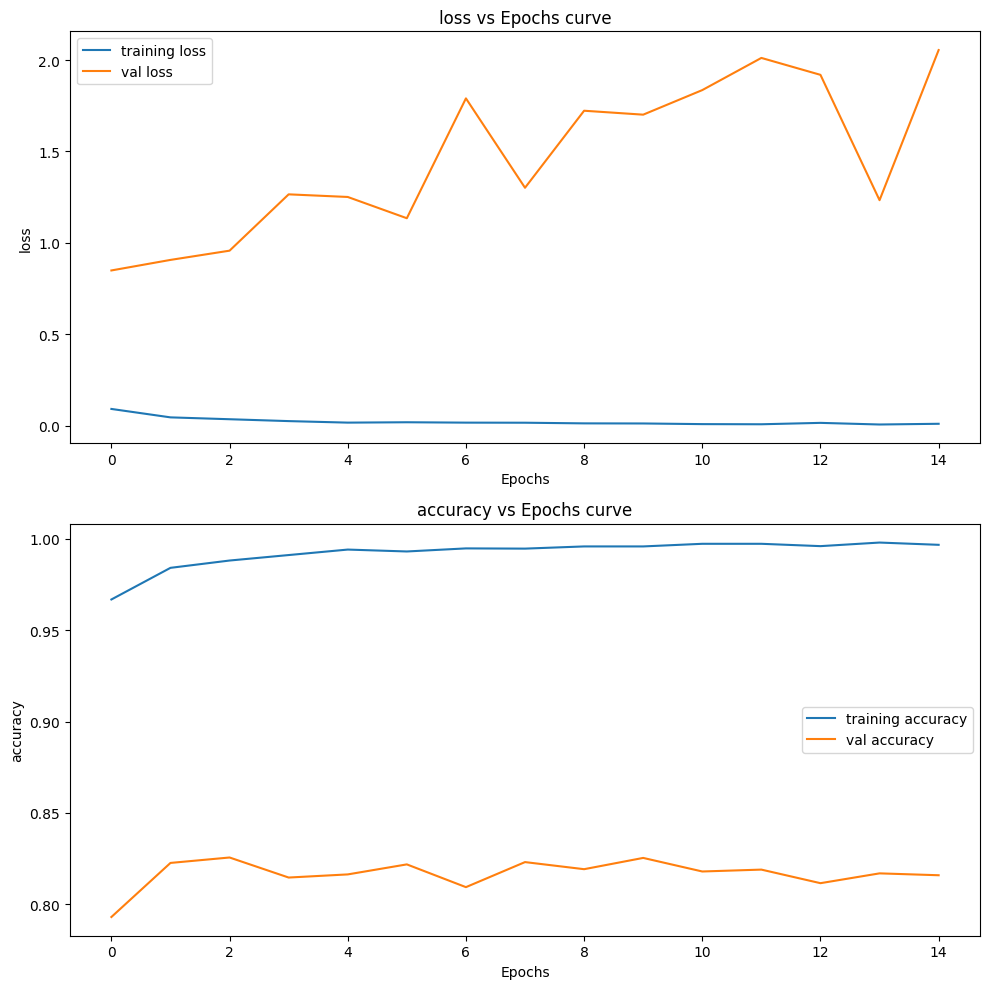

In [ ]:
# Plot loss curves
plot_loss_curves(model_5_history, metrics_to_plot = ['loss',
                                                     'accuracy'])

In [ ]:
# Get best weights model
model_5.load_weights('model_exp/model_5_lstm')
model_5.evaluate(test_dataset)

547/547 [==============================] - 7s 13ms/step - loss: 0.9573 - accuracy: 0.8256


[0.9572860598564148, 0.8256000280380249]

In [ ]:
# Make predictions using the model
model_5_preds = tf.squeeze(tf.round(model_5.predict(test_dataset)))
model_5_preds[:10]

547/547 [==============================] - 8s 13ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 0., 0., 1., 1., 1., 1., 0., 0.], dtype=float32)>

In [ ]:
# Get evaluation metrics
model_5_results = calculate_metrics(y_true = test_label_lst,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 0.8256,
 'precision': 0.8257329935281862,
 'recall': 0.8256,
 'f1': 0.8255497478565573}

In [ ]:
model_4_results, model_3_results, model_2_results, model_1_results

({'accuracy': 0.8467428571428571,
  'precision': 0.8468594594617213,
  'recall': 0.8467428571428571,
  'f1': 0.8467054191241818},
 {'accuracy': 0.852,
  'precision': 0.8521029763276994,
  'recall': 0.852,
  'f1': 0.8519671893208023},
 {'accuracy': 0.8608,
  'precision': 0.8628887310534102,
  'recall': 0.8608,
  'f1': 0.860674641835069},
 {'accuracy': 0.8716571428571429,
  'precision': 0.8719366208139356,
  'recall': 0.8716571428571429,
  'f1': 0.8716565846442259})

### Model 6: same as model 5, but with regularisation layerss, and other acitvation functions

In [ ]:
from tensorflow.keras import regularizers

# Set the random seed
tf.random.set_seed(42)

# Create the model
inputs = layers.Input(shape=(1,), dtype=tf.string, name='input_layer')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, return_sequences = True)(x)
x = layers.Dropout(0.35)(x)
x = layers.LSTM(64, return_sequences = True)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(48, 11, activation='elu')(x)
x = layers.MaxPool1D(4, 2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv1D(36, 11, activation='elu')(x)
x = layers.MaxPool1D(4, 2)(x)
x = layers.Dropout(0.2)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation='elu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dense(32, activation='elu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)
model_6 = tf.keras.Model(inputs, outputs, name='model_6')

In [ ]:
# Compile the model
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.experimental.Adamax(),
                metrics='accuracy')

# Create a LR scheduler
schedule = lambda epoch: 1e-4 * 10 ** (epoch/4)
lr = tf.keras.callbacks.LearningRateScheduler(schedule)

# Fit the model
model_6_history = model_6.fit(train_dataset,
                              epochs = 15,
                              steps_per_epoch = len(train_dataset),
                              validation_data = test_dataset,
                              validation_steps = len(test_dataset),
                              callbacks = [create_model_checkpoint(
                                  save_dir = 'model_exp/model_6_lstm_comp'
                              ),
                                           lr])

Epoch 1/15
1563/1563 [==============================] - 93s 38ms/step - loss: 0.3686 - accuracy: 0.9294 - val_loss: 0.7429 - val_accuracy: 0.8142 - lr: 1.0000e-04
Epoch 2/15
1563/1563 [==============================] - 42s 27ms/step - loss: 0.2927 - accuracy: 0.9564 - val_loss: 0.9005 - val_accuracy: 0.8175 - lr: 1.7783e-04
Epoch 3/15
1563/1563 [==============================] - 50s 32ms/step - loss: 0.2253 - accuracy: 0.9758 - val_loss: 0.9362 - val_accuracy: 0.8224 - lr: 3.1623e-04
Epoch 4/15
1563/1563 [==============================] - 47s 30ms/step - loss: 0.1756 - accuracy: 0.9863 - val_loss: 1.0371 - val_accuracy: 0.8248 - lr: 5.6234e-04
Epoch 5/15
1563/1563 [==============================] - 41s 26ms/step - loss: 0.1375 - accuracy: 0.9892 - val_loss: 1.0936 - val_accuracy: 0.8209 - lr: 0.0010
Epoch 6/15
1563/1563 [==============================] - 41s 26ms/step - loss: 0.1027 - accuracy: 0.9902 - val_loss: 1.0556 - val_accuracy: 0.8205 - lr: 0.0018
Epoch 7/15
1563/1563 [========

In [ ]:
model_6.evaluate(test_dataset)

547/547 [==============================] - 10s 18ms/step - loss: 0.6586 - accuracy: 0.6402


[0.6586191058158875, 0.6402285695075989]

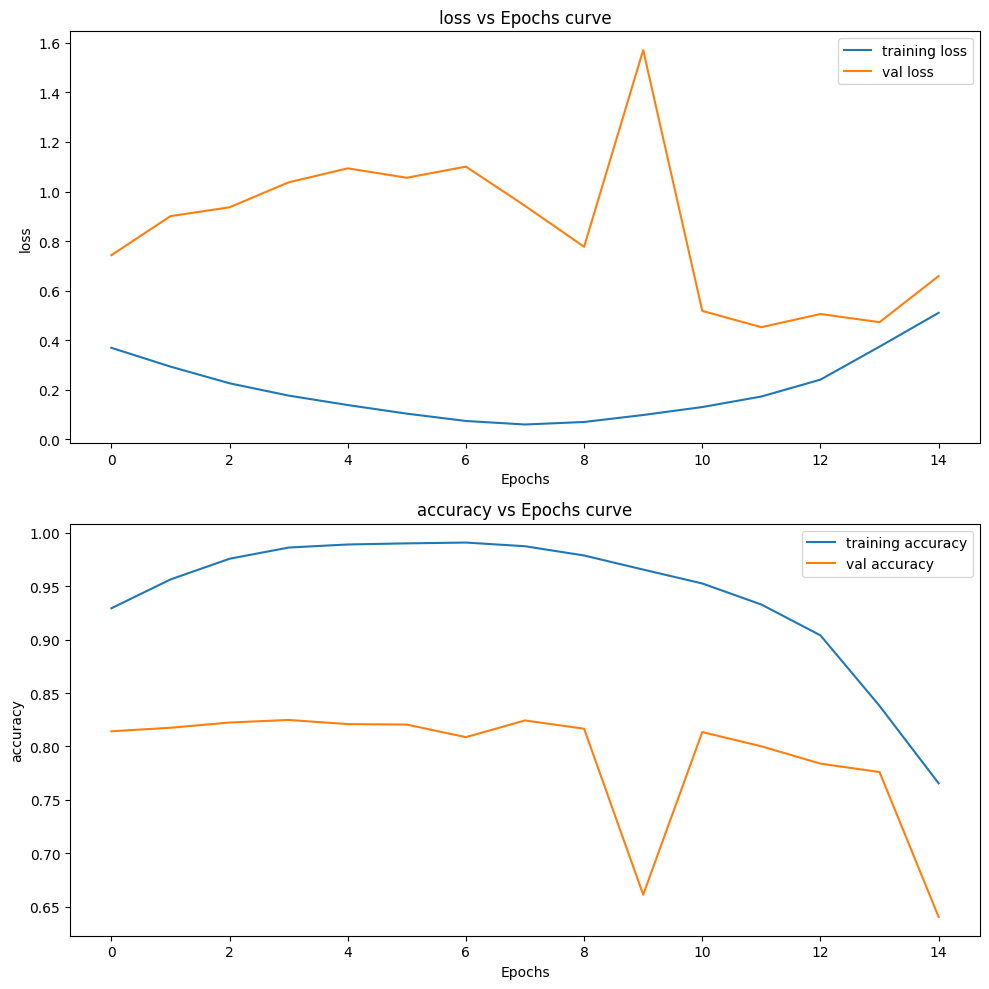

In [ ]:
# Plot loss curve
plot_loss_curves(model_6_history)

In [ ]:
# Load the best weights model
model_6.load_weights('model_exp/model_6_lstm_comp')
model_6.evaluate(test_dataset)

547/547 [==============================] - 10s 17ms/step - loss: 1.0371 - accuracy: 0.8248


[1.0371322631835938, 0.8248000144958496]

In [ ]:
# Make predictions using the model
model_6_preds = tf.squeeze(tf.round(model_6.predict(test_dataset)))
model_6_preds[:10]

547/547 [==============================] - 13s 22ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 0., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_6_results = calculate_metrics(y_true=test_label_lst,
                                    y_pred = model_6_preds)

In [ ]:
model_6_results

{'accuracy': 0.8248,
 'precision': 0.8247971026914032,
 'recall': 0.8248,
 'f1': 0.8247937995757549}

### Model 7: GRU model

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers

model_7_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_7")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_7_embedding(x)
x = layers.GRU(64, return_sequences=True)(x) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64, return_sequences=True)(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_7 = tf.keras.Model(inputs, outputs, name="model_7_GRU")

In [ ]:
# Compile GRU model
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy",
                         tf.keras.metrics.BinaryCrossentropy(
                             name = 'binary_crossentropy'
                         )])

# making a model checkpoint callback
mc = tf.keras.callbacks.ModelCheckpoint(filepath = 'model_exp/model_7_gru',
                                        verbose = 0,
                                        monitor = 'val_binary_crossentropy',
                                        save_weights_only=True,
                                        save_best_only = True)

# Making an earlystopping callback
esc = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                       verbose = 0,
                                       mode = 'max',
                                       patience = 5,
                                       restore_best_weights = True)

# Fit the model
model_7_history = model_7.fit(train_dataset,
                              epochs = 20,
                              steps_per_epoch = len(train_dataset),
                              validation_data = test_dataset,
                              validation_steps = int(0.4*len(test_dataset)),
                              callbacks = [mc, esc])

Epoch 1/20
1563/1563 [==============================] - 58s 34ms/step - loss: 0.0268 - accuracy: 0.9916 - binary_crossentropy: 0.0268 - val_loss: 0.7394 - val_accuracy: 0.8394 - val_binary_crossentropy: 0.7394
Epoch 2/20
1563/1563 [==============================] - 34s 22ms/step - loss: 0.0115 - accuracy: 0.9960 - binary_crossentropy: 0.0115 - val_loss: 0.7776 - val_accuracy: 0.8380 - val_binary_crossentropy: 0.7776
Epoch 3/20
1563/1563 [==============================] - 34s 22ms/step - loss: 0.0081 - accuracy: 0.9970 - binary_crossentropy: 0.0081 - val_loss: 0.9331 - val_accuracy: 0.8392 - val_binary_crossentropy: 0.9331
Epoch 4/20
1563/1563 [==============================] - 34s 22ms/step - loss: 0.0096 - accuracy: 0.9968 - binary_crossentropy: 0.0096 - val_loss: 1.0191 - val_accuracy: 0.8340 - val_binary_crossentropy: 1.0191
Epoch 5/20
1563/1563 [==============================] - 33s 21ms/step - loss: 0.0070 - accuracy: 0.9980 - binary_crossentropy: 0.0070 - val_loss: 1.1046 - val_a

In [ ]:
# Evaluate using the model
model_7.evaluate(test_dataset)

547/547 [==============================] - 6s 10ms/step - loss: 0.7282 - accuracy: 0.8405 - binary_crossentropy: 0.7282


[0.7282066941261292, 0.8404571413993835, 0.7282066941261292]

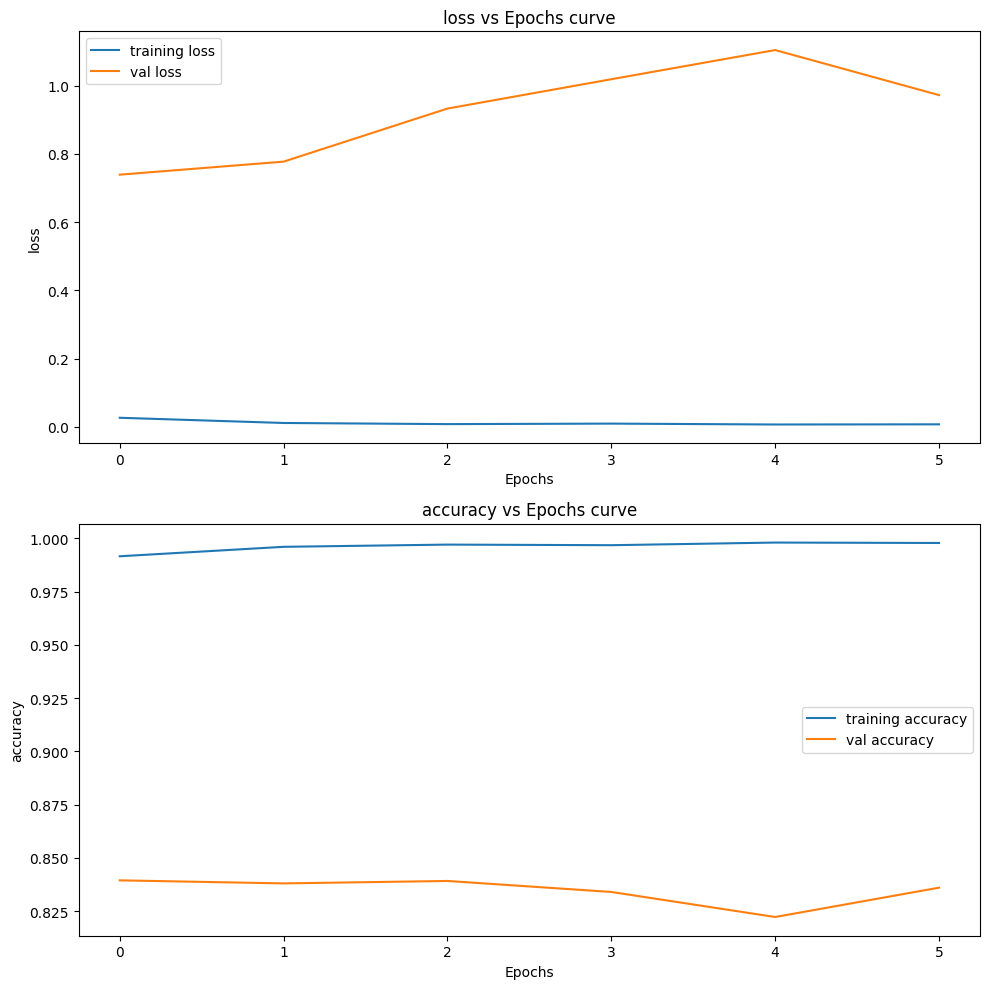

In [ ]:
# Plot the loss curves
plot_loss_curves(model_7_history)

In [ ]:
# Get the best weights model
model_7.load_weights('model_exp/model_7_gru')
model_7.evaluate(test_dataset)

547/547 [==============================] - 7s 13ms/step - loss: 0.7282 - accuracy: 0.8405 - binary_crossentropy: 0.7282


[0.7282066941261292, 0.8404571413993835, 0.7282066941261292]

In [ ]:
# Make predictions using the model
model_7_preds = tf.squeeze(tf.round(model_7.predict(test_dataset)))
model_7_preds[:10]

547/547 [==============================] - 6s 10ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 0., 0., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Get evaluation metrics
model_7_results = calculate_metrics(y_true = test_label_lst,
                                    y_pred = model_7_preds)

In [ ]:
model_7_results

{'accuracy': 0.8404571428571429,
 'precision': 0.8443942205268198,
 'recall': 0.8404571428571429,
 'f1': 0.840125940939869}

### Model 8: Bidirectional-LSTM

In [28]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers

model_8_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=256,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_8")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_8_embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(48, activation='elu')(x)
x = layers.Dense(24, activation='elu')(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_8 = tf.keras.Model(inputs, outputs, name="model_8_Bidirectional")

In [ ]:
mc.filepath

'model_exp/model_8_bidirectional'

In [30]:
# # Compile the model
# model_8.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#                 optimizer = tf.keras.optimizers.experimental.Adamax(),
#                 metrics = ['accuracy'])

# Create model_checkpoint callback
mc = tf.keras.callbacks.ModelCheckpoint(filepath='model_exp/model_8_bidirectional',
                                        verbose=0,
                                        monitor='val_accuracy',
                                        mode='max',
                                        save_best_only=True,
                                        save_weights_only=True)

# Fit the model
history_model_8, eval_model_8 = get_range_epoch_results(
    model_8,
    epoch_lst=[5, 10, 15, 20, 25],
    loss_fn="binary_crossentropy",
    train_data=train_dataset,
    use_best_only = True,
    test_data=test_dataset,
    optimizer = tf.keras.optimizers.experimental.Adam()
)

Fitting and training the model: 
  Initial epochs: 0
  Total epochs: 5

Trained the model till 5 epochs!!!

Model saved at checkpoint path: `model_exp/model_8_Bidirectional_0.ckpt`
Loading the best weights model 1
Getting the evaluation results
547/547 [==============================] - 9s 17ms/step - loss: 0.3062 - accuracy: 0.8702

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 5
  Total epochs: 10

Trained the model till 10 epochs!!!

Model saved at checkpoint path: `model_exp/model_8_Bidirectional_1.ckpt`
Loading the best weights model 2
Getting the evaluation results
547/547 [==============================] - 8s 15ms/step - loss: 0.3112 - accuracy: 0.8706

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 10
  Total epochs: 15

Trained the model till 15 epochs!!!

Model saved at checkpoint path: `model_exp/model_8_Bidirectional_2.ckpt`
Loading the best weights model 3
Getti

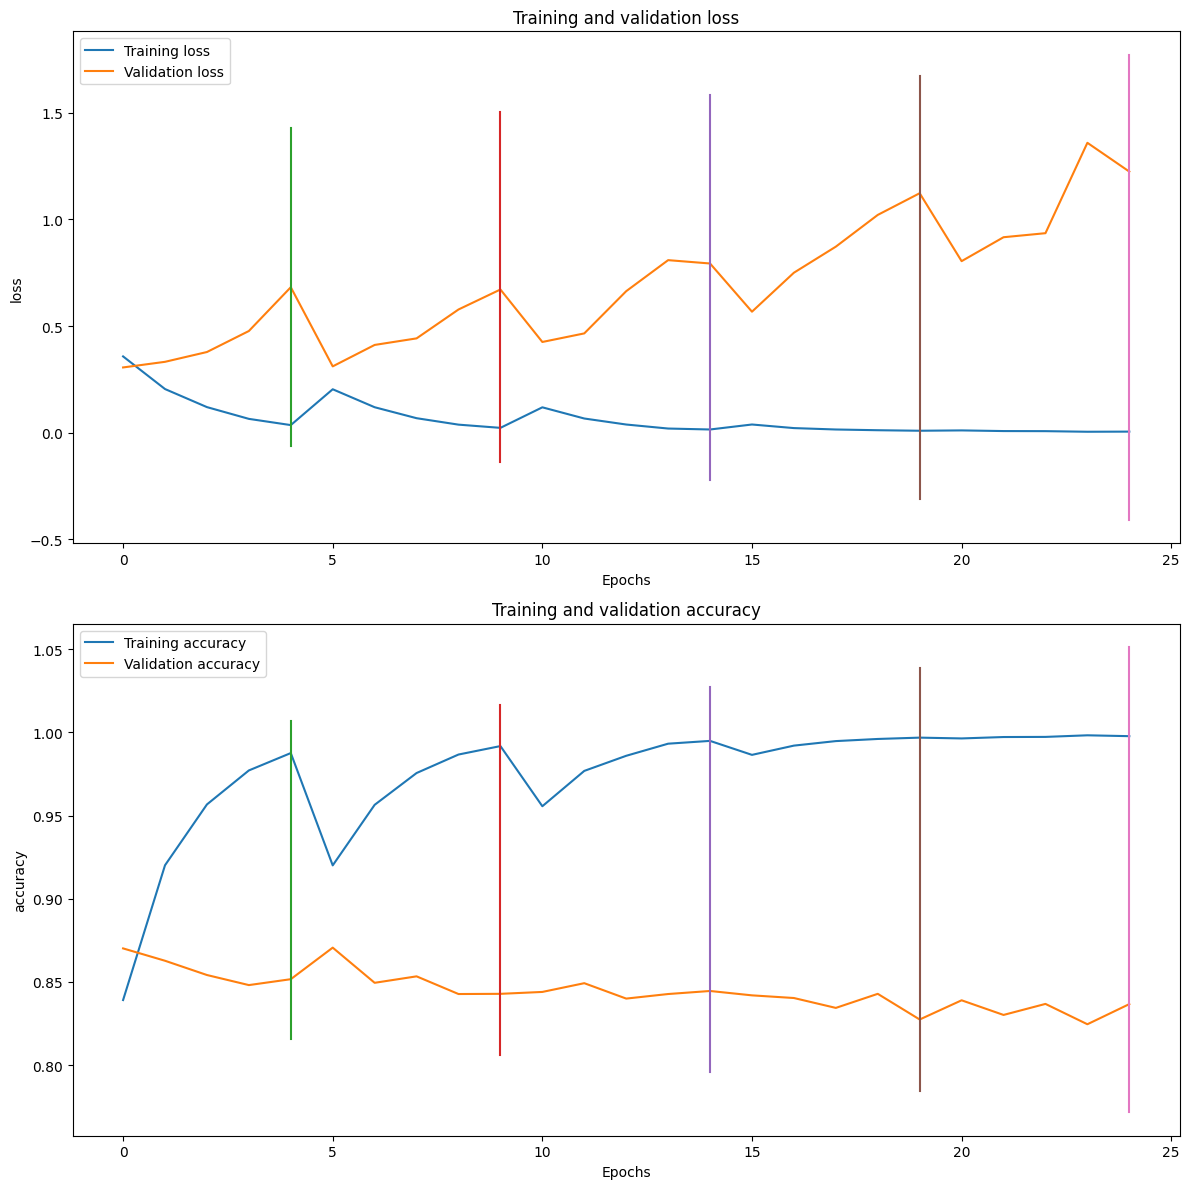

In [31]:
compare_history_overall(history_lst=history_model_8,
                        initial_epoch_lst=[5, 10, 15, 20, 25])

### Model 9: Using Tensorflow hub pretrained sentence encoder

In [32]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.00274225 -0.0451887   0.02080956  0.03594081 -0.0381479   0.0752725
  0.01817022 -0.02279351  0.07460125  0.01033872 -0.02727009 -0.0336256
  0.00440512 -0.06324854  0.05938795 -0.06656388 -0.02788     0.02160665
  0.07190673  0.04235555  0.05167459 -0.08737578  0.02961344  0.00384556
  0.0800413  -0.05964284 -0.0354079   0.05703059  0.01036698  0.08670196
  0.05689427  0.02048063  0.03763063  0.00686376  0.0455508  -0.02218007
  0.04957075  0.00850963 -0.07359084 -0.05249315  0.0010964   0.00596902
 -0.08149845 -0.04004175 -0.07345377  0.04981083 -0.00779202 -0.00672865
  0.06836458  0.01098883], shape=(50,), dtype=float32)


In [33]:
# Making a USE layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [35]:
from tensorflow.keras import Sequential
# Create the model
model_9 = Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='elu'),
    layers.Dense(1, activation='sigmoid')
], name='model_9_USE')

# Fit the model
history_model_9, eval_model_9 = get_range_epoch_results(
    model_8,
    epoch_lst=[5, 10, 15, 20],
    loss_fn="binary_crossentropy",
    use_best_only = True,
    train_data=train_dataset,
    test_data=test_dataset,
    optimizer = tf.keras.optimizers.experimental.Adam()
)

Fitting and training the model: 
  Initial epochs: 0
  Total epochs: 5

Trained the model till 5 epochs!!!

Model saved at checkpoint path: `model_exp/model_8_Bidirectional_0.ckpt`
Loading the best weights model 1
Getting the evaluation results
547/547 [==============================] - 9s 16ms/step - loss: 0.9140 - accuracy: 0.8371

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 5
  Total epochs: 10

Trained the model till 10 epochs!!!

Model saved at checkpoint path: `model_exp/model_8_Bidirectional_1.ckpt`
Loading the best weights model 2
Getting the evaluation results
547/547 [==============================] - 9s 17ms/step - loss: 1.1452 - accuracy: 0.8394

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 10
  Total epochs: 15

Trained the model till 15 epochs!!!

Model saved at checkpoint path: `model_exp/model_8_Bidirectional_2.ckpt`
Loading the best weights model 3
Getti

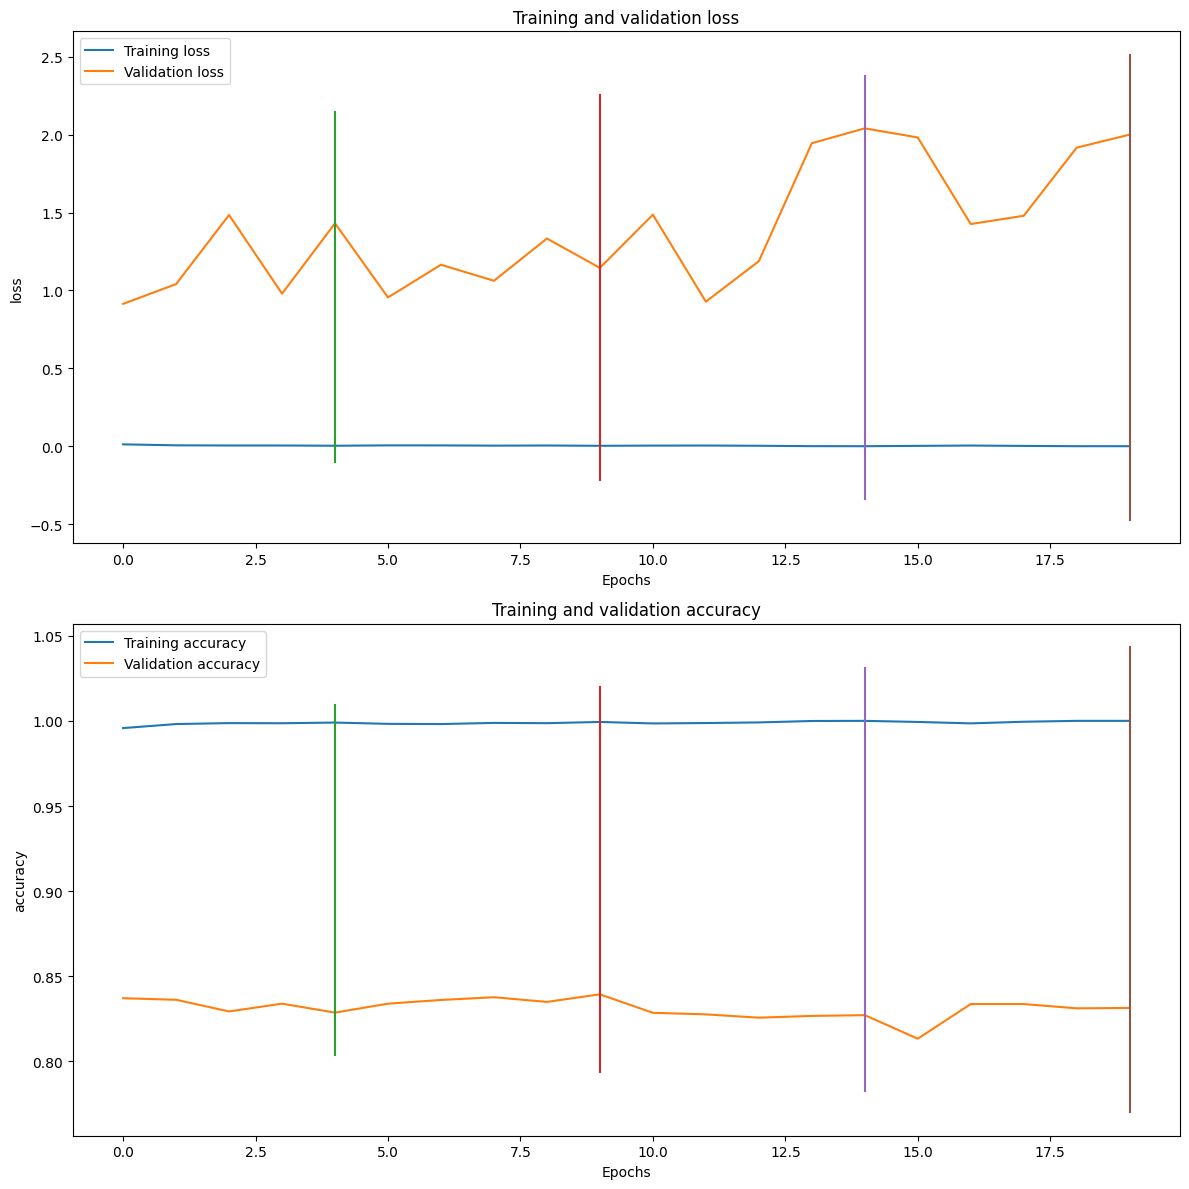

In [36]:
compare_history_overall(history_lst=history_model_9,
                        initial_epoch_lst=[5, 10, 15, 20])

###